In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import re

import mapel.elections as mapel
from scripts.gurobi import gurobi_ilp
from scripts.basin_hopping import basin_hopping
from scripts.approvalwise_vector import get_approvalwise_vectors, sample_election_from_approvalwise_vector

from tqdm.notebook import tqdm

import time

plt.rcParams['figure.dpi'] = 140

In [2]:
to_purge_elections_ids_regexes = [
    '.*empty.*',
    '.*full.*',
    '.*IC.*',
    '.*ID.*',
    '.*background_.*',
    '.*FES.*',
    '.*compass.*',
]

def add_compass(experiment: mapel.ApprovalElectionExperiment, extended: bool = False):
    experiment.add_election(culture_id='full', election_id = 'FULL', color='red')
    experiment.add_election(culture_id='empty', election_id = 'EMPTY', color='blue')
    experiment.add_election(culture_id='ic', params={'p': 0.5}, election_id = 'IC 0.5', color='green')
    experiment.add_election(culture_id='id', params={'p': 0.5}, election_id = 'ID 0.5', color='orange')
    
    experiment.add_empty_family(family_id='compass')
    
    sample_election = next(iter(experiment.elections.values()))
    num_candidates = sample_election.num_candidates
    num_voters = sample_election.num_voters

    if extended:
        for p in np.linspace(0, 1, 11):
            for phi in np.linspace(0, 1, 11):
                election = mapel.generate_approval_election(
                    election_id=f'p={p:.1f}, phi={phi:.1}',
                    num_candidates=num_candidates, 
                    num_voters=num_voters, 
                    culture_id='resampling', 
                    params={'p': p, 'phi': phi}
                    )
                experiment.add_election_to_family(election, family_id='compass')

def show_2d_map_with_compass(experiment: mapel.ApprovalElectionExperiment, extended: bool = False, show_legend: bool = True):
    add_compass(experiment, extended=extended)
    experiment.compute_distances(distance_id='l1-approvalwise')
    experiment.embed_2d(embedding_id="fr")
    experiment.print_map_2d(legend=show_legend)
    

    
def generate_farthest_elections_l1_approvalwise(experiment: mapel.ApprovalElection, num_generated: int, generator):
    meaningful_elections = get_meaningful_elections_from_experiment(experiment)
    approvalwise_vectors = get_approvalwise_vectors(meaningful_elections)
    new_approvalwise_vectors = []
    new_distances = []
    execution_times = []
    
    family_id='New farthest elections'
    experiment.add_empty_family(family_id=family_id, color='orange')
    
    current_experiment_size = len(experiment.elections)
    sample_election = next(iter(experiment.elections.values()))
    num_candidates = sample_election.num_candidates
    num_voters = sample_election.num_voters

    experiment_sizes = list(range(current_experiment_size, current_experiment_size + num_generated))

    for idx in tqdm(range(num_generated)):
        start = time.time()
        
        approvalwise_vector, distance = generator(approvalwise_vectors, num_voters)
        new_approvalwise_vectors.append(approvalwise_vector)
        new_distances.append(distance)
        election = sample_election_from_approvalwise_vector(approvalwise_vector, num_voters)
        
        execution_times.append(time.time() - start)
        
        election.instance_id = f'ILP-{idx}'
        election.num_candidates = num_candidates
        
        approvalwise_vectors.append(approvalwise_vector)
        experiment.add_election_to_family(election, family_id=family_id)
    
    report = pd.DataFrame({
        'experiment_size': experiment_sizes,
        'execution_time': execution_times,
        'distance': new_distances
    })

    return new_approvalwise_vectors, report

def plot_report(report: pd.DataFrame): 
    plt.scatter(report.experiment_size, report.distance)
    plt.plot(report.experiment_size, report.distance, '--')
    plt.title('Distance to the closest election')
    plt.xlabel('Experiment size')
    plt.ylabel('Distance to the closest election')
    plt.ylim(0, None)
    plt.show()

    plt.scatter(report.experiment_size, report.execution_time)
    plt.plot(report.experiment_size, report.execution_time, '--')
    plt.title('Execution time')
    plt.xlabel('Experiment size')
    plt.ylabel('Execution time [s]')
    plt.show()
    


def get_meaningful_elections_from_experiment(experiment):
    to_purge_regex = '|'.join(to_purge_elections_ids_regexes)
    elections = experiment.elections
    return {instance_id: election for instance_id, election in elections.items() if not re.match(to_purge_regex, instance_id)}

In [3]:
generator = lambda approvalwise_vectors, num_voters: basin_hopping(
    approvalwise_vectors, 
    num_voters, 
    niter=5000, 
    step_size=7, 
    seed=2137, 
    big_step_chance=0.2,
    x0='random'
)

# Approval online experiments

## Euclidean File

In [5]:
experiments = {}
reports = {}
new_approval_vectors_per_experiment = {}

Preparing instances: 100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


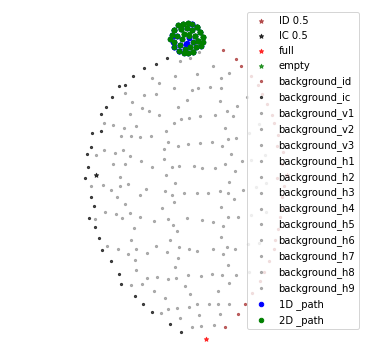

  0%|          | 0/12 [00:00<?, ?it/s]

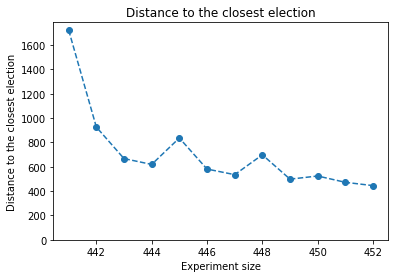

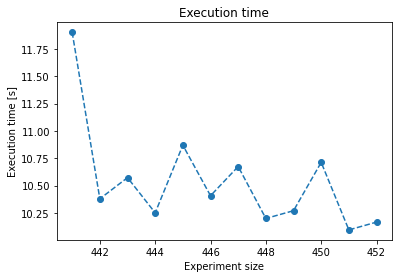

Computing distances: 100%|██████████| 102378/102378 [01:41<00:00, 1006.91it/s]


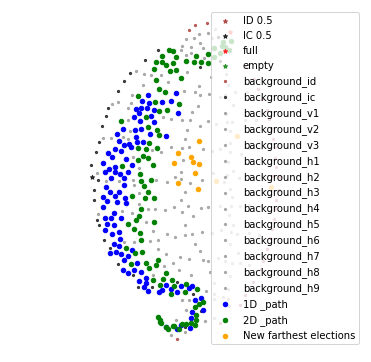

In [22]:
experiment_id = 'euclidean'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment = mapel.prepare_offline_approval_experiment(
    experiment_id=f'{num_candidates}x{num_voters}/{experiment_id}',
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

experiment.print_map_2d()

new_approvalwise_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated, generator)
plot_report(report)

experiments[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()

# Noise resampling File

Preparing instances: 100%|██████████| 27/27 [00:03<00:00,  7.58it/s]


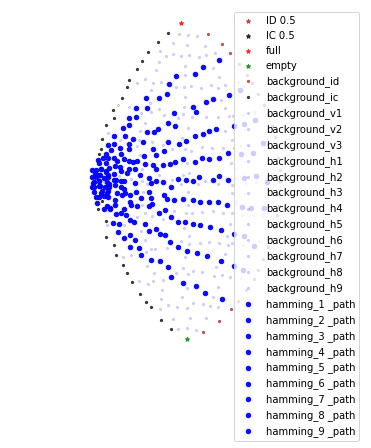

  0%|          | 0/12 [00:00<?, ?it/s]

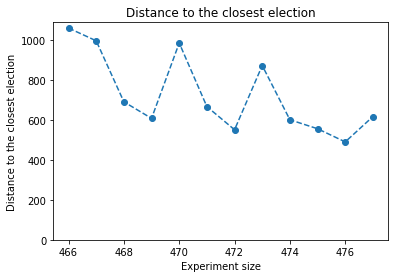

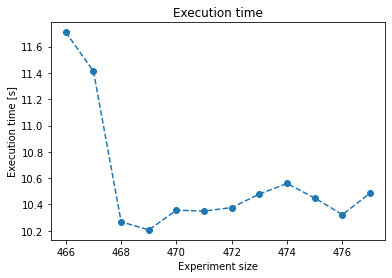

In [14]:
experiment_id = 'noise'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment = experiment_50_100 = mapel.prepare_offline_approval_experiment(
    experiment_id=f'{num_candidates}x{num_voters}/{experiment_id}',
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

experiment.print_map_2d()


new_approvalwise_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated, generator)
plot_report(report)

experiments[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()

Computing distances: 100%|██████████| 114003/114003 [02:04<00:00, 917.09it/s]


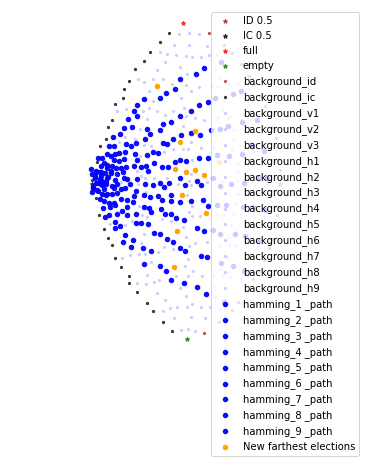

# Truncated urn File

Preparing instances: 100%|██████████| 27/27 [00:01<00:00, 19.30it/s]


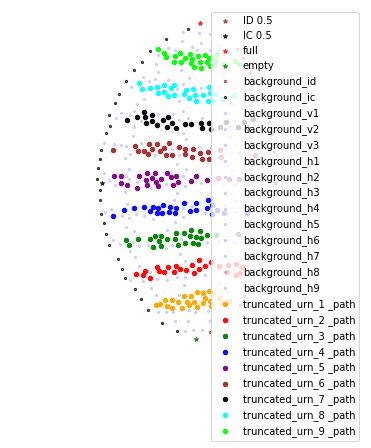

  0%|          | 0/12 [00:00<?, ?it/s]

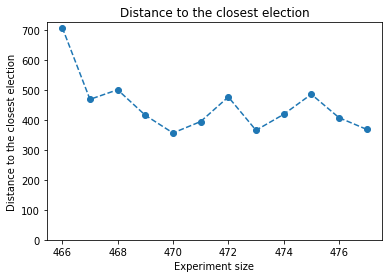

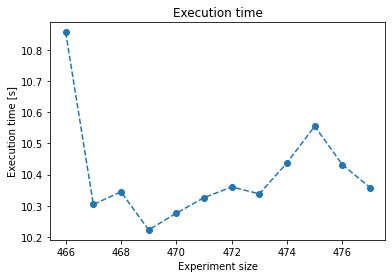

Computing distances: 100%|██████████| 114003/114003 [02:00<00:00, 949.75it/s] 


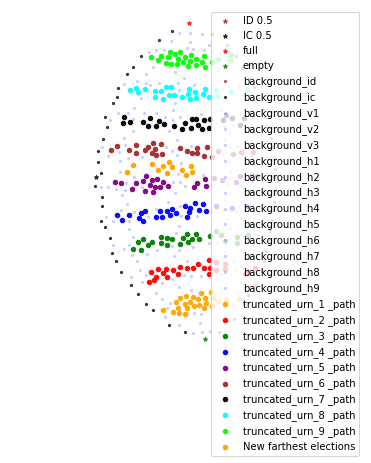

In [23]:
experiment_id = 'truncated_urn'

num_generated = 12

num_candidates = 50
num_voters = 100

experiment = mapel.prepare_offline_approval_experiment(
    experiment_id=f'{num_candidates}x{num_voters}/{experiment_id}',
    distance_id="l1-approvalwise",
    embedding_id="fr"
)
experiment.prepare_elections()

experiment.print_map_2d()


new_approvalwise_vectors, report = generate_farthest_elections_l1_approvalwise(experiment, num_generated, generator)
plot_report(report)

experiments[experiment_id] = experiment
reports[experiment_id] = report
new_approval_vectors_per_experiment[experiment_id] = new_approvalwise_vectors

experiment.compute_distances(distance_id='l1-approvalwise')
experiment.embed_2d(embedding_id="fr")
experiment.print_map_2d()